# Importing libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
df = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
df.columns = df.columns.droplevel(1) 
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.440332,6.455078,6.391280,6.422878,493729600
2010-01-05,6.451466,6.487879,6.417460,6.458087,601904800
2010-01-06,6.348845,6.477044,6.342225,6.451465,552160000
2010-01-07,6.337108,6.379842,6.291065,6.372318,477131200
2010-01-08,6.379240,6.379842,6.291368,6.328683,447610800


Price,Close,High,Low,Open,Volume
count,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03
mean,57.574681,58.154507,56.940304,57.532586,2.422834e+08
std,55.520111,56.088908,54.889501,55.463714,2.204578e+08
min,5.779478,5.898345,5.725307,5.789106,2.404830e+07
25%,16.948899,17.103423,16.785682,16.966750,9.266760e+07
50%,29.039497,29.255417,28.786080,29.039399,1.526602e+08
75%,88.776262,90.046464,88.015218,88.781723,3.284715e+08
max,196.927673,198.428656,195.824294,196.838214,1.880998e+09


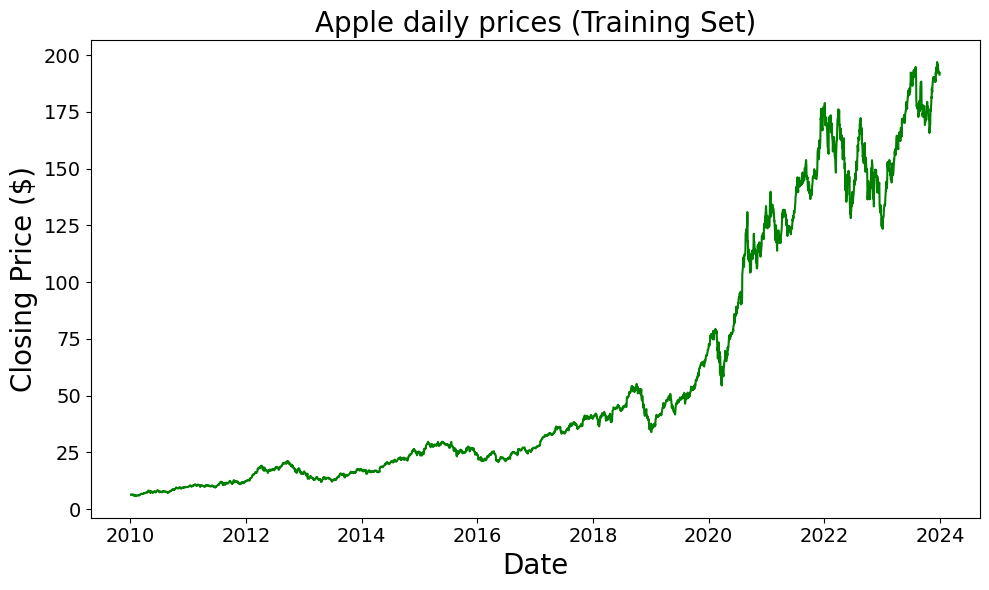

In [3]:
plt.figure(figsize=(10,6))
plt.plot(
  df.index,
  df['Close'],
  #label="Close Price ($)",
  color="green"
)
#plt.legend(fontsize=18, loc="upper left")
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel("Closing Price ($)", fontsize=20)
plt.title("Apple daily prices (Training Set)", fontsize=20)
plt.tight_layout()
df.describe()

# Scaling

In [4]:
X, y = df.drop(columns=['Close']), df['Close'].values

mm = MinMaxScaler()
ss = StandardScaler()
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))    # Scaling is crucial for NNs

## Preparing data

In [7]:
def split_sequences(input_sequences, output_sequences, n_steps_in, n_steps_out):
    X, y = list(), list() #Instantiate X and y
    for i in range(len(input_sequences)):
        # Find the end of the input, output sequence
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out - 1

        # Check if we are beyond the dataset
        if out_end_idx > len(input_sequences):
            break
        # Gather input and output of the pattern
        seq_x = input_sequences[i:end_idx]
        seq_y = output_sequences[end_idx-1:out_end_idx, - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50) # Let's try to predict 50 days based on 100
print(X_ss.shape, y_mm.shape)

(3374, 100, 4) (3374, 50)


Let's check that the first sample in `y_mm` indeed starts at the 100th sample in the original target `y` vector.

In [8]:
y_mm[0]

array([0.0081961 , 0.00965081, 0.01020656, 0.01082843, 0.01131965,
       0.01118897, 0.01006173, 0.0092714 , 0.00901792, 0.00805284,
       0.00920369, 0.00967601, 0.00979722, 0.01064897, 0.01183918,
       0.01256654, 0.01291288, 0.01229889, 0.01287824, 0.01242483,
       0.01211468, 0.01175257, 0.0120045 , 0.01009477, 0.00936427,
       0.00888411, 0.00864165, 0.00890772, 0.01048835, 0.01039707,
       0.01063793, 0.0102711 , 0.00940679, 0.00955321, 0.00935168,
       0.00910765, 0.00842755, 0.00942096, 0.00979092, 0.01054345,
       0.01068832, 0.01058441, 0.01134011, 0.0108489 , 0.0104002 ,
       0.01026481, 0.01098903, 0.01100162, 0.01116692, 0.0109654 ])

In [9]:
y_trans[99:149].squeeze(1)

array([0.0081961 , 0.00965081, 0.01020656, 0.01082843, 0.01131965,
       0.01118897, 0.01006173, 0.0092714 , 0.00901792, 0.00805284,
       0.00920369, 0.00967601, 0.00979722, 0.01064897, 0.01183918,
       0.01256654, 0.01291288, 0.01229889, 0.01287824, 0.01242483,
       0.01211468, 0.01175257, 0.0120045 , 0.01009477, 0.00936427,
       0.00888411, 0.00864165, 0.00890772, 0.01048835, 0.01039707,
       0.01063793, 0.0102711 , 0.00940679, 0.00955321, 0.00935168,
       0.00910765, 0.00842755, 0.00942096, 0.00979092, 0.01054345,
       0.01068832, 0.01058441, 0.01134011, 0.0108489 , 0.0104002 ,
       0.01026481, 0.01098903, 0.01100162, 0.01116692, 0.0109654 ])

In [11]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

## Train/Test split

We want to predict the data several months into the future. Thus, we'll use a training data size of 95% , with 5% left for the data we want to predict.

In [ ]:
total_samples = len(X_ss)
train_test_cutoff = round(total_samples * 0.95)

X_train, X_test = X_ss[:train_test_cutoff], X_ss[train_test_cutoff:]
y_train, y_test = y_mm[:train_test_cutoff], y_mm[train_test_cutoff:]
print("The meaning of each dimension in order: batch size, sequence length, number of features (input size)")
print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Testing shape: {X_test.shape}, {y_test.shape}")
print(f"Total samples: {total_samples}\nCutoff idx: {train_test_cutoff}")    

The meaning of each dimension in order: batch size, sequence length, number of features
Training shape: (3205, 100, 4), (3205, 50)
Testing shape: (169, 100, 4), (169, 50)
Total samples: 3374
Cutoff idx: 3205


## Converting to tensors

In [30]:
X_train_tensors = torch.tensor(X_train)
X_test_tensors = torch.tensor(X_test)

y_train_tensors = torch.tensor(y_train)
y_test_tensors = torch.tensor(y_test)


print(X_train_tensors.shape, y_train_tensors.shape)
print(X_test_tensors.shape, y_test_tensors.shape)

torch.Size([3205, 100, 4]) torch.Size([3205, 50])
torch.Size([169, 100, 4]) torch.Size([169, 50])


Check if the 50 values we will be predicting match the last 50 values of `y` in the test set

In [32]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[1.77448042e+02, 1.75048891e+02, 1.75435531e+02, 5.59644000e+07],
       [1.77804968e+02, 1.75237269e+02, 1.75802366e+02, 9.96253000e+07],
       [1.78568330e+02, 1.75405808e+02, 1.76169179e+02, 6.89018000e+07],
       [1.80214026e+02, 1.77715731e+02, 1.79470487e+02, 6.19459000e+07]])

In [33]:
X.iloc[-149:-145]

Price,High,Low,Open,Volume
Date,,,,
2023-05-30,177.448042,175.048891,175.435531,55964400
2023-05-31,177.804968,175.237269,175.802366,99625300
2023-06-01,178.568330,175.405808,176.169179,68901800
2023-06-02,180.214026,177.715731,179.470487,61945900


In [34]:
y_check[-1]

array([174.18336487, 171.62217712, 171.74127197, 172.17807007,
       169.85510254, 165.67570496, 166.99604797, 169.05096436,
       169.52749634, 172.70422363, 176.27801514, 175.36471558,
       177.92591858, 180.49711609, 181.55931091, 181.08280945,
       185.28753662, 183.69709778, 186.3213501 , 186.88793945,
       188.57780457, 188.5579071 , 190.30740356, 189.50224304,
       190.16824341, 188.83624268, 188.65730286, 189.26367188,
       188.23982239, 188.81636047, 190.09867859, 188.29945374,
       192.26564026, 191.17222595, 193.11058044, 194.54199219,
       192.02706909, 193.54797363, 196.77856445, 196.92767334,
       196.39089966, 194.72091675, 195.76464844, 193.66725159,
       193.51812744, 192.44458008, 191.89787292, 191.99726868,
       192.42471313, 191.38095093])

In [35]:
df['Close'].values[-50:]

array([174.18336487, 171.62217712, 171.74127197, 172.17807007,
       169.85510254, 165.67570496, 166.99604797, 169.05096436,
       169.52749634, 172.70422363, 176.27801514, 175.36471558,
       177.92591858, 180.49711609, 181.55931091, 181.08280945,
       185.28753662, 183.69709778, 186.3213501 , 186.88793945,
       188.57780457, 188.5579071 , 190.30740356, 189.50224304,
       190.16824341, 188.83624268, 188.65730286, 189.26367188,
       188.23982239, 188.81636047, 190.09867859, 188.29945374,
       192.26564026, 191.17222595, 193.11058044, 194.54199219,
       192.02706909, 193.54797363, 196.77856445, 196.92767334,
       196.39089966, 194.72091675, 195.76464844, 193.66725159,
       193.51812744, 192.44458008, 191.89787292, 191.99726868,
       192.42471313, 191.38095093])

## Building the LSTM model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 = nn.Linear(hidden_size,128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # Input, hidden and internal state
        hn = hn.view(-1, self.hidden_size) # Reshaping data for dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM_Network().to(device)

criterion = nn.MSELoss() # We'll use Mean Squared Error as our loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # And Adam as our optimizer

## Training the model

In [ ]:
def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(0, n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # Forward pass
        optimizer.zero_grad() # Calculate the gradient, manually setting to 0
        # Obtain loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # Calculates the loss of the loss function
        optimizer.step() # Improve from loss, i.e backprop
        # Test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Train Loss: {round(loss.item(),5)}, Test Loss: {round(test_loss.item(),5)}")

In [ ]:
n_epochs = 1000
learning_rate = 0.001

input_size = 4 # Nr of features
hidden_size = 2 # Nr of features in hidden state
num_layers = 1 # Nr of stacked LSTM layers

num_classes = 50 # Nr of output classes

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)#.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [ ]:
training_loop(n_epochs=n_epochs, 
              lstm=lstm, 
              optimizer=optimizer, 
              loss_fn=loss_fn, 
              X_train=X_train_tensors, 
              y_train=y_train_tensors, 
              X_test=X_test_tensors, 
              y_test=y_test_tensors)

## Evaluating model

In [52]:
model.eval()
with torch.no_grad():
    test_features = torch.tensor(np.array([s[0] for s in test_sequences]), dtype=torch.float32).to(device)
    #test_labels = torch.tensor(np.array([s[1] for s in test_sequences]), dtype=torch.float32).unsqueeze(1).to(device)
    test_predictions = model(test_features).cpu().numpy()

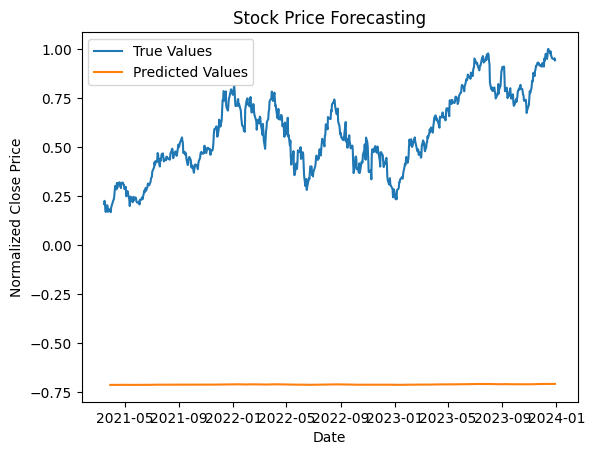

In [53]:
dates = df.index.values
plt.plot(dates[train_size:len(X)], test_data, label='True Values')
plt.plot(dates[train_size+seq_length:len(X)], test_predictions, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Stock Price Forecasting')
plt.legend()
plt.show()

In [54]:
df[train_size:len(X)]

Price,Close,High,Low,Open,Volume
Date,,,,,
2021-03-15,121.292046,121.301830,117.799727,118.768191,92403800
2021-03-16,122.837692,124.451791,122.006189,122.964861,115227900
2021-03-17,122.045288,123.121351,119.677940,121.350738,111932600
2021-03-18,117.907349,120.499688,117.701919,120.206213,121229700
2021-03-19,117.379105,118.787774,117.075852,117.291067,185549500
...,...,...,...,...,...
2023-12-22,192.444595,194.243791,191.818350,194.015153,37122800
2023-12-26,191.897873,192.732856,191.679185,192.454528,28919300
2023-12-27,191.997253,192.345171,189.949550,191.341204,48087700
